**TUTORIAL MULTI-STRATEGY SERIAL-REFINE (MSR) OPTIMIZATION ALGORITHM**

The algorithm utilized in this example is an extended and generalized version of the Serial-Refine optimizer introduced by Fleming et al. (2022), and described in --CITE PAPER ONCE SUBMITTED--.

The purpose of the algorithm is to optimize the operation of a wind farm adopting multiple control strategies and a generalized objective for a given flow condition.

Underlying principle: the turbines are sorted from the most upstream to the most downstream, optimizing the control variable sequentially. This method assumes that the decision on the control variable of a downstream turbine has limited impact on the decision for an upstream turbine, due to the directionality of the flow.

Flexibility:
- Black-box objective function: any type of objective function is accepted, allowing a multi-objective approach
- Multiple control strategy: any control strategy can be defined by the user by specifying the control variable for each of them

In [1]:
# import main packages
import numpy as np
import time
from numpy import newaxis as na
import pickle

# import optimizer
from msr import MSR_optimizer
from msr import ObjFuncComponent

**EXAMPLE 1 : SERIAL-REFINE FOR YAW OPTIMIZATION (TRADITIONAL METHOD)**

**CASE STUDY**

**Define objective function**: in this case a wind farm model implemented within PyWake is import and used together with a function that calculated the power of the wind farm. These function are defined elsewhere to keep the document clean but any type of objective function can be defined at this stage.

**Define objective fuction parameters**: the objective function must receive as input the control variable (in this case *yaw*) and can receive additional parameters which must be defined before the optimization.

In [2]:
# import wind farm model, HKN data and power wrapper 
from py_wake_helix.py_wake_helix_tools import Power_wrapper
with open(f'HKNscaled_IEA22MW.pkl', 'rb') as f:
    data = pickle.load(f)

# define objective functions
def calculate_power_wake_steering(x,y,wfm,wd,ws,yaw):
    f_temp =  Power_wrapper(x = x,
                            y = y,
                            wfm = wfm,
                            wd = wd,
                            ws = ws)
    helix_amp =  np.zeros_like(yaw)
    return f_temp(yaw[:,na,na],helix_amp[:,na,na])

# define objective functions parameters
wfm = data['wfm_EmpGauss']
diameter = data['diameter']
x = data['x']
y = data['y']
ws = 8.
wd = 201.

**OPTMIZATION**

**Create the objective function component**: the name of the control variable is specified and the other parameters are assigned.

**Create the optimizer object**: it requires the positions (x,y) and the wind direction (wd) to enable the sorting of the turbines.

**Add wind farm control strategy**: the strategy is added by specifying the name of the strategy, the name of the optimizatio variable and the optimization method with its parameters.

**Run optimization**

In [3]:
# create objective function component
f_obj = ObjFuncComponent(obj_func = calculate_power_wake_steering,
                         input_keys = ['yaw'],
                         x = x,
                         y = y,
                         wfm = wfm,
                         wd = wd,
                         ws = ws)

# create optimizer object
optimizer_MSR = MSR_optimizer(x = x,
                              y = y,
                              wd = wd,
                              f_obj = f_obj,
                              n_step = 3,
                              exclusivity = True
                              )

# add strategy (Wake steering - Refine)
optimizer_MSR.add_strategy(str_name = 'Wake steering',
                           var_name = 'yaw',
                           opt_method = 'Refine',
                           n_values = 5,
                           cmin = -30.,
                           cmax = 30.)

# run optimization
t = time.time()
optimizer_MSR.optimize()
t_Refine = time.time()-t

# save results
c_opt = optimizer_MSR.c_opt
yaw_opt_Refine = c_opt['yaw']
f_opt_Refine = optimizer_MSR.f_opt

print(f'Optimization (Wake steering - Refine) - Time:{time.time()-t}')

Optimization (Wake steering - Refine) - Time:54.8207631111145


**Visualization of the results**

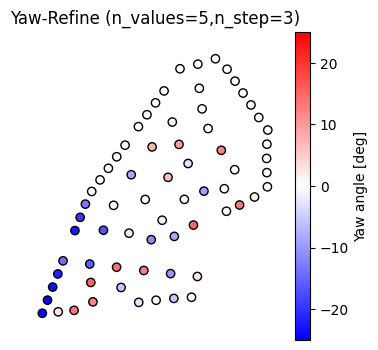

In [4]:
import matplotlib.pyplot as plt

# plot control variables - Yaw-Refine (n_values=5,n_step=3)
plt.figure(figsize=(4,4))
plt.title('Yaw-Refine (n_values=5,n_step=3)')
sc = plt.scatter(x,y,c=yaw_opt_Refine,cmap='bwr',vmin=-25.,vmax=25.,edgecolors='black')
cbar = plt.colorbar(sc)
cbar.set_label('Yaw angle [deg]')
plt.axis('off')
plt.axis('equal')
plt.show()

**EXAMPLE 2 : MULTIPLE METHODS FOR YAW OPTIMIZATION**

The case study and the results from the Serial-Refine example are reused in this example.

**Method: Discrete**

The yaw angles can assumes values of -20, 0, 20 deg.

In [5]:
# create objective function object
f_obj = ObjFuncComponent(obj_func = calculate_power_wake_steering,
                         input_keys = ['yaw'],
                         x = x,
                         y = y,
                         wfm = wfm,
                         wd = wd,
                         ws = ws)

# create optimizer object
optimizer_MSR = MSR_optimizer(x = x,
                              y = y,
                              wd = wd,
                              f_obj = f_obj,
                              n_step = 3,
                              exclusivity = True
                              )

# add strategy (Wake steering - Discrete)
optimizer_MSR.add_strategy(str_name = 'Wake steering',
                           var_name = 'yaw',
                           opt_method = 'Discrete',
                           c_values_array = np.array([-20.,0.,20.]))

# run optimization
t = time.time()
optimizer_MSR.optimize()
t_Discrete = time.time()-t

# save results
c_opt = optimizer_MSR.c_opt
yaw_opt_Discrete = c_opt['yaw']
f_opt_Discrete = optimizer_MSR.f_opt

print(f'Optimization (Wake steering - Discrete) - Time:{time.time()-t}')


Optimization (Wake steering - Discrete) - Time:33.171159505844116


**Method: Geomtric-SR**

The yaw angles can assume either their geometric yaw value based on Baricchio et al. (2024) or 0 deg. 

In [6]:
# calculate effective wind speed (needed for Geometric yaw)
ws_eff = wfm(x,y,wd=np.array([wd]),ws=np.array([ws]),yaw=np.zeros((len(x),1,1)),helix_amp=np.zeros((len(x),1,1)),tilt=0.).WS_eff_ilk.reshape(-2)

# create objective function object
f_obj = ObjFuncComponent(obj_func = calculate_power_wake_steering,
                         input_keys = ['yaw'],
                         x = x,
                         y = y,
                         wfm = wfm,
                         wd = wd,
                         ws = ws)

# create optimizer object
optimizer_MSR = MSR_optimizer(x = x,
                              y = y,
                              wd = wd,
                              f_obj = f_obj,
                              n_step = 3,
                              exclusivity = True
                              )

# add strategy (Wake steering - Geometric yaw)
optimizer_MSR.add_strategy(str_name = 'Wake steering',
                           var_name = 'yaw',
                           opt_method = 'Geometric yaw',
                           geom_yaw_method = 'Exponential corrected',
                           ws_rated = 11.,
                           diameter = diameter,
                           ws_eff = ws_eff)

# run optimization
t = time.time()
optimizer_MSR.optimize()
t_Geom = time.time()-t

# save results
c_opt = optimizer_MSR.c_opt
yaw_opt_Geom = c_opt['yaw']
f_opt_Geom = optimizer_MSR.f_opt

print(f'Optimization (Wake steering - Geom) - Time:{time.time()-t}')

Optimization (Wake steering - Geom) - Time:22.86570715904236


**Visualization of the results**

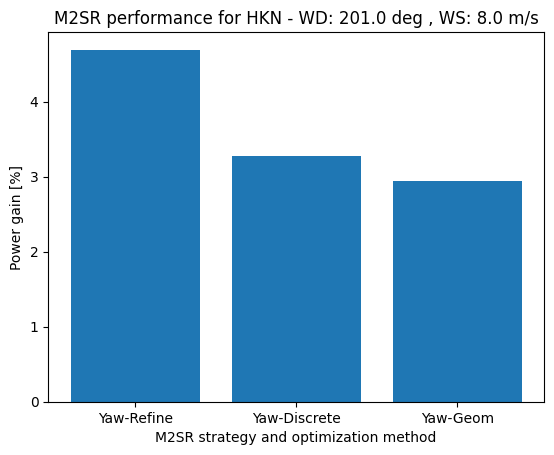

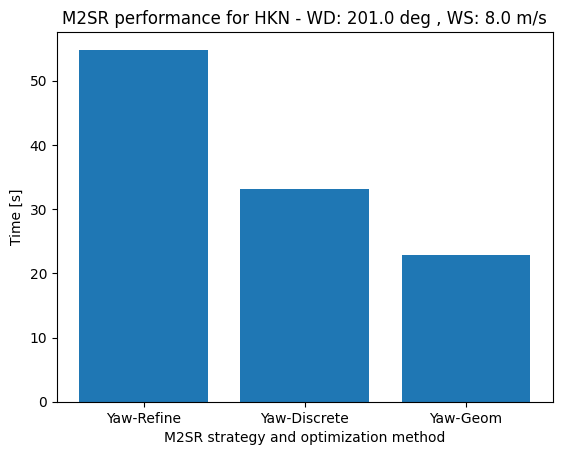

In [7]:
# calculate improvement in the objective function (i.e. power in this example)
f_baseline = calculate_power_wake_steering(x,y,wfm,wd,ws,yaw=np.zeros(len(x)))
f_gain_Refine = 100*(f_opt_Refine-f_baseline)/f_baseline
f_gain_Discrete = 100*(f_opt_Discrete-f_baseline)/f_baseline
f_gain_Geom = 100*(f_opt_Geom-f_baseline)/f_baseline

labels = ['Yaw-Refine','Yaw-Discrete','Yaw-Geom']

# plot imp power gains rovement
f_gains = [f_gain_Refine,f_gain_Discrete,f_gain_Geom]
plt.title(f'M2SR performance for HKN - WD: {wd} deg , WS: {ws} m/s')
plt.bar(np.arange(len(f_gains)),f_gains)
plt.xticks(ticks=range(len(f_gains)),labels=labels)
plt.xlabel('M2SR strategy and optimization method')
plt.ylabel('Power gain [%]')
plt.show()

# plot time
t_list = [t_Refine,t_Discrete,t_Geom]
plt.title(f'M2SR performance for HKN - WD: {wd} deg , WS: {ws} m/s')
plt.bar(np.arange(len(t_list)),t_list)
plt.xticks(ticks=range(len(t_list)),labels=labels)
plt.xlabel('M2SR strategy and optimization method')
plt.ylabel('Time [s]')
plt.show()


**EXAMPLE 3 : COMBINED YAW-HELIX OPTIMIZATION**

This example assumes that the same turbine cannot apply two different control strategies simultaneously (exlusivity of the control strategies).

Define a new objective function that includes also the helix amplitude for each turbine as input parameter.

In [8]:
def calculate_power_combined(x,y,wfm,wd,ws,yaw,helix_amp):
    f_temp =  Power_wrapper(x = x,
                            y = y,
                            wfm = wfm,
                            wd = wd,
                            ws = ws)
    return f_temp(yaw[:,na,na],helix_amp[:,na,na])


Repeat the same steps explained above and add an additional strategy (i.e. the Helix).

In [9]:
# create objective function component
f_obj = ObjFuncComponent(obj_func = calculate_power_combined,
                         input_keys = ['yaw','helix_amp'],
                         x = x,
                         y = y,
                         wfm = wfm,
                         wd = wd,
                         ws = ws)

# create optimizer object
optimizer_MSR = MSR_optimizer(x = x,
                              y = y,
                              wd = wd,
                              f_obj = f_obj,
                              n_step = 3,
                              exclusivity = True
                              )

# add strategy (Wake steering - Refine)
optimizer_MSR.add_strategy(str_name = 'Wake steering',
                           var_name = 'yaw',
                           opt_method = 'Refine',
                           n_values = 5,
                           cmin = -30.,
                           cmax = 30.)

# add strategy (Helix - Refine)
optimizer_MSR.add_strategy(str_name = 'Helix',
                           var_name = 'helix_amp',
                           opt_method = 'Refine',
                           n_values = 5,
                           cmin = 0.,
                           cmax = 5.)

# run optimization
t = time.time()
optimizer_MSR.optimize()
t_combined = time.time()-t

# save results
c_opt = optimizer_MSR.c_opt
yaw_opt_combined = c_opt['yaw']
helix_amp_opt_combined = c_opt['helix_amp']
f_opt_combined = optimizer_MSR.f_opt

print(f'Optimization (Combined - Refine) - Time:{time.time()-t}')

Optimization (Combined - Refine) - Time:122.54964804649353


**Visualization of the results**

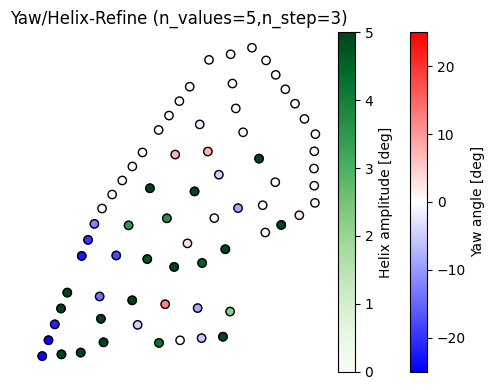

In [10]:
# plot control variables - Yaw-Helix combined
fig, ax = plt.subplots(figsize=(6,4))
ax.set_title('Yaw/Helix-Refine (n_values=5,n_step=3)')
fil_helix = helix_amp_opt_combined>0.
fil_yaw = np.abs(yaw_opt_combined)>0.
sc1 = ax.scatter(x[fil_yaw],y[fil_yaw],c=yaw_opt_combined[fil_yaw],cmap='bwr',vmin=-25.,vmax=25)
sc2 = ax.scatter(x[fil_helix],y[fil_helix],c=helix_amp_opt_combined[fil_helix],cmap='Greens',vmin=0.,vmax=5.)
sc = ax.scatter(x,y,facecolors='none',edgecolors='black')
cbar1 = fig.colorbar(sc1,ax=ax, orientation='vertical',fraction=0.046,pad=0.1)
cbar1.set_label('Yaw angle [deg]')
cbar2 = fig.colorbar(sc2,ax=ax,orientation='vertical',fraction=0.046,pad=0.02)
cbar2.set_label('Helix amplitude [deg]')
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


**References**

Fleming, P. A., Stanley, A., Bay, C., King, J., Simley, E., Doekemeijer, B., and Mudafort, R.: Serial-Refine Method for Fast Wake-Steering Yaw Optimization, J. Phys. Conf. Ser., 2265, 032109, https://doi.org/10.1088/1742-6596/2265/3/032109, 2022

Baricchio, M., Gebraad, P. M. O., and van Wingerden, J.-W.: Evaluating the potential of a wake steering co-design for wind farm layout optimization through a tailored genetic algorithm, Wind Energ. Sci., 9, 2113–2132, https://doi.org/10.5194/wes-9-2113-2024, 2024

Baricchio et al. .... PAPER COMING